In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings

# --- CONFIGURATION & BRAIDNG ---
warnings.filterwarnings('ignore')
sns.set_theme(style="white", context="talk") 
# Define a strategic color palette
colors = {
    'baseline': '#95a5a6', # Neutral Gray
    'growth': '#27ae60',   # Growth Green
    'core': '#2c3e50',     # Core Navy
    'new': '#e74c3c',      # Alert Red
    'highlight': '#f1c40f' # Peak Yellow
}

# Helper function for professional axis formatting (e.g., 1.2M instead of 1200000)
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.1f%s' % (num, ['', 'K', 'M', 'B'][magnitude])

formatter = ticker.FuncFormatter(human_format)

# --- PHASE 0: DATA ENGINEERING ---
Goal: Transform raw transaction data into a time-series ready format

In [6]:
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['revenue'] = df['units_sold'] * df['price_unit']
    df['year'] = df['date'].dt.year
    df['month_start'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df['week_start'] = df['date'].dt.to_period('W').dt.to_timestamp()
    return df

df = load_and_preprocess('FMCG_2022_2024.csv')

# --- PHASE 1: PROMOTION ROI ANALYSIS ---
Goal: Quantify the 'Sales Lift' to evaluate Trade Spend efficiency

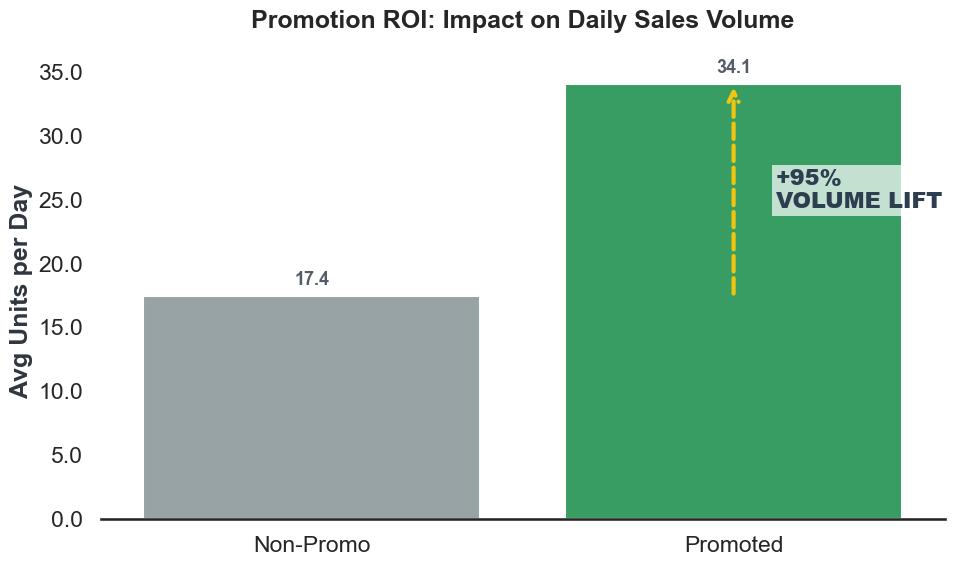

In [14]:
def analyze_promo_lift(df):
    # 1. Data Aggregation: Calculate average daily volume per promotion status
    promo_stats = df.groupby('promotion_flag').agg(
        avg_vol=('units_sold', 'mean')
    ).reset_index()
    
    # Mapping labels for clarity
    promo_stats['label'] = promo_stats['promotion_flag'].map({0: 'Non-Promo', 1: 'Promoted'})
    
    # Metrics for annotation
    baseline = promo_stats.loc[0, 'avg_vol']
    promoted = promo_stats.loc[1, 'avg_vol']
    lift = (promoted - baseline) / baseline
    
    # 2. Visualization Setup
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Draw bars with Hue assignment to avoid future deprecation warnings
    bars = sns.barplot(
        data=promo_stats, 
        x='label', 
        y='avg_vol', 
        hue='label', 
        palette=[colors['baseline'], colors['growth']], 
        legend=False
    )
    
    # 3. Add Data Labels on top of bars (Professional Grey for subtlety)
    for p in bars.patches:
        ax.annotate(
            f'{p.get_height():.1f}', 
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha='center', va='bottom', 
            fontweight='bold', fontsize=13,
            color='#535c68', xytext=(0, 5), textcoords='offset points'
        )
    
    # 4. Growth Indicator: Arrow & Callout
    # Arrow stays Green to signify growth
    ax.annotate(
        '', xy=(1, promoted), xytext=(1, baseline),
        arrowprops=dict(arrowstyle='->', color=colors['highlight'], lw=3, ls='--')
    )
    
    # Text uses Core Navy for high contrast and readability
    ax.text(
        1.1, (baseline + promoted)/2, 
        f'+{lift:.0%}\nVOLUME LIFT', 
        color=colors['core'], # Contrast color to avoid blending with bars
        fontweight='extra bold', 
        fontsize=16, 
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3) # Semi-transparent background
    )
    
    # 5. Final Polishing
    plt.title('Promotion ROI: Impact on Daily Sales Volume', fontsize=18, fontweight='bold', pad=25)
    plt.ylabel('Avg Units per Day', fontweight='bold', color='#2f3640')
    plt.xlabel('')
    
    # Apply custom formatter for clean axis
    ax.yaxis.set_major_formatter(formatter)
    
    # Despine for a modern, clean look
    sns.despine(left=True)
    
    plt.tight_layout()
    plt.show()

# Execute analysis
analyze_promo_lift(df)

# --- PHASE 2: SEASONALITY & DEMAND PLANNING ---
Goal: Identify cyclical peaks to optimize production and safety stock

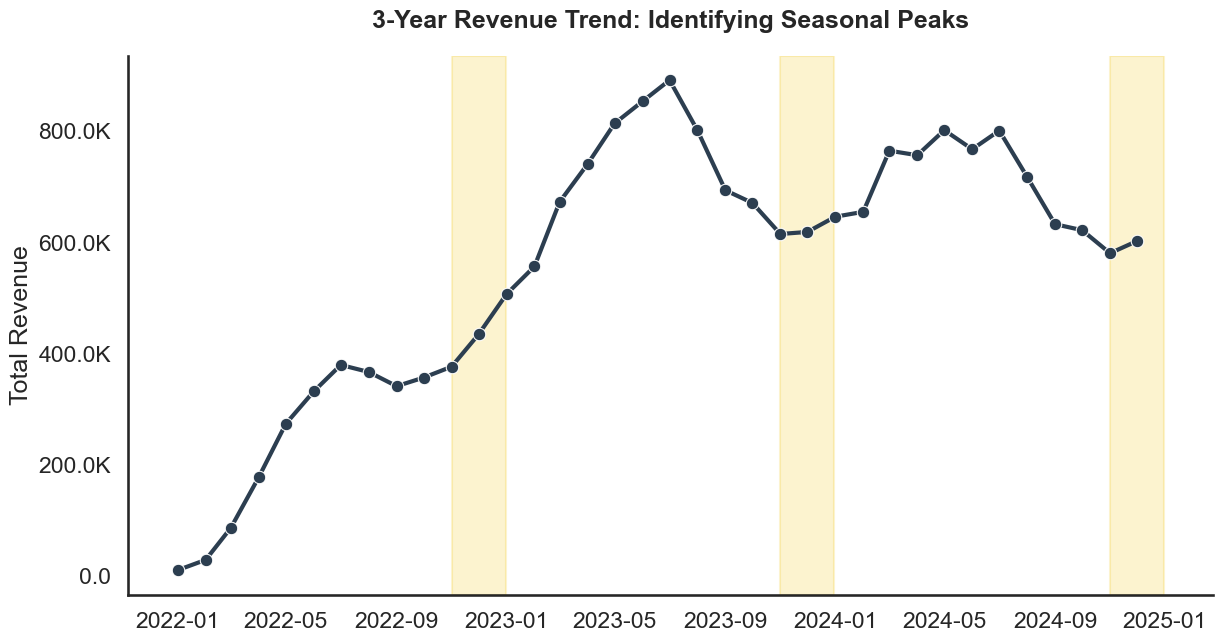

In [8]:
def analyze_seasonality(df):
    monthly = df.groupby('month_start')['revenue'].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly, x='month_start', y='revenue', color=colors['core'], lw=3, marker='o')
    
    # Highlight Peak Seasons (Year-End)
    for year in df['year'].unique():
        plt.axvspan(pd.to_datetime(f'{year}-11-01'), pd.to_datetime(f'{year}-12-31'), 
                    color=colors['highlight'], alpha=0.2, label='Peak Season' if year == 2022 else "")
    
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.title('3-Year Revenue Trend: Identifying Seasonal Peaks', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Total Revenue')
    plt.xlabel('')
    sns.despine()
    plt.show()

analyze_seasonality(df)

# --- PHASE 3: PORTFOLIO STRATEGY (CANNIBALIZATION) ---
Goal: Analyze impact of 2024 New Launches on Core Portfolio

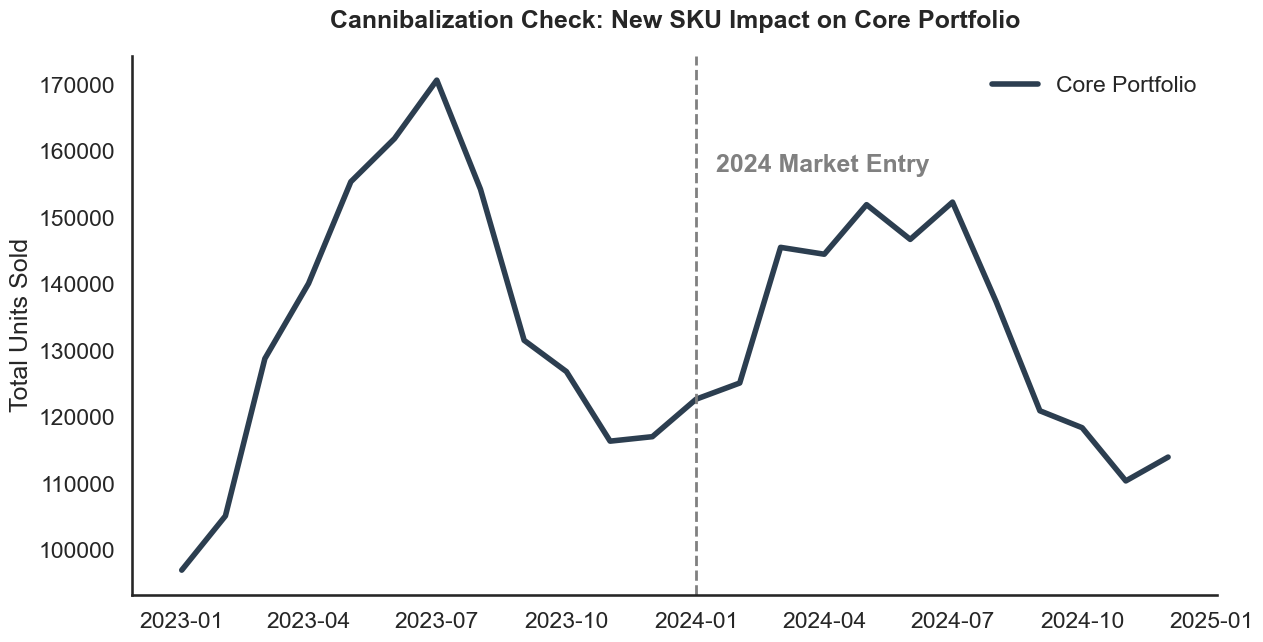

In [16]:
def analyze_cannibalization(df):
    # Find new SKUs launched in 2024 (Cold Start SKUs)
    sku_birth = df.groupby('sku')['year'].min()
    new_skus = sku_birth[sku_birth == 2024].index.tolist()
    
    df['segment'] = np.where(df['sku'].isin(new_skus), 'New Launch (2024)', 'Core Portfolio')
    
    # Compare volume from 2023 to 2024
    comparison = df[df['year'] >= 2023].groupby(['month_start', 'segment'])['units_sold'].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=comparison, x='month_start', y='units_sold', hue='segment', 
                 palette={'Core Portfolio': colors['core'], 'New Launch (2024)': colors['new']}, lw=4)
    
    # Annotate Launch Point
    plt.axvline(pd.to_datetime('2024-01-01'), color='gray', ls='--', lw=2)
    plt.text(pd.to_datetime('2024-01-15'), plt.ylim()[1]*0.9, '2024 Market Entry', fontweight='bold', color='gray')
    
    plt.title('Cannibalization Check: New SKU Impact on Core Portfolio', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Total Units Sold')
    plt.xlabel('')
    plt.legend(frameon=False)
    sns.despine()
    plt.show()

analyze_cannibalization(df)